***PLEASE READ BEFORE RUNNING THE CODE***

Mount Google Drive: Before running the notebook, users need to mount their Google Drive to access the necessary files. This can be done by adding the following code at the top of the notebook:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download the LoRA weights from [this link](https://drive.google.com/file/d/1Utk2vVupV1fxHqMaUaA6uj-tl-aLIj0m/view?usp=sharing) and place it in the appropriate directory in your Google Drive.


Link to DeepCache-master folder -  https://drive.google.com/drive/folders/1LAsyld33UTeW4cha8FHQakIQqkADplqz?usp=sharing

Ensure that the **lora_weights_path** variable below in code, points to the correct path in your own Google Drive where you have stored the HD Horizon v1_0.safetensors file.

In [6]:
pip install deepcache

In [3]:
!pip install diffusers peft transformers accelerate
!pip install torch torchvision diffusers transformers accelerate
!pip install safetensors




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 8.5 MB/s eta 0:00:00


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading LoRA weights from safetensors...
LoRA Weights Loaded Successfully.
Type of LoRA Weights: <class 'dict'>
Warmup GPU...


  0%|          | 0/50 [00:00<?, ?it/s]

Running Original Pipeline...


  0%|          | 0/50 [00:00<?, ?it/s]

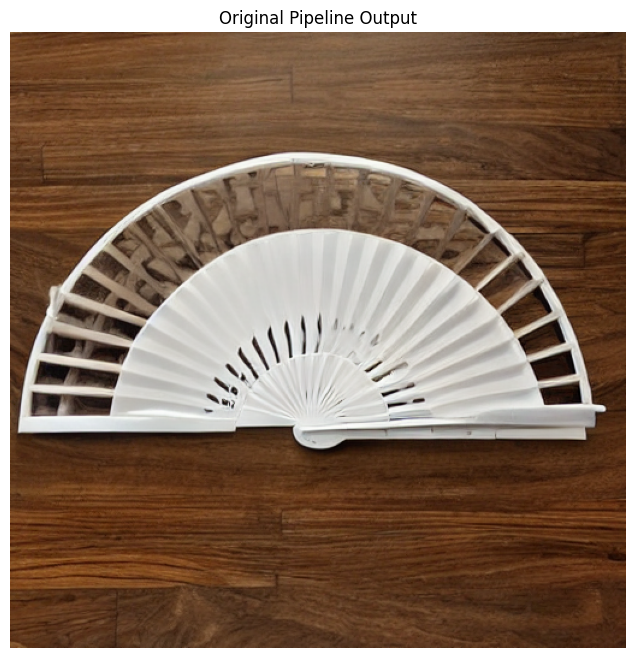

Enable DeepCache...
Running Pipeline with DeepCache and LoRA...


  0%|          | 0/50 [00:00<?, ?it/s]

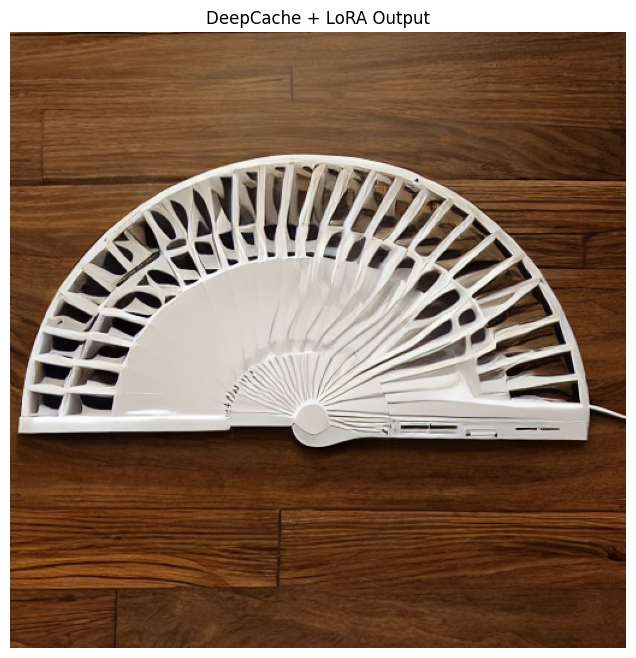

Done! Original Pipeline: 7.75 seconds, DeepCache + LoRA: 3.48 seconds. Speedup Ratio = 2.23


In [10]:
import argparse
import time
import torch
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
from safetensors.torch import load_file
import sys
import os

# Add the path where deepcache.py is located
sys.path.append('/content/drive/MyDrive/DeepCache-master/DeepCache/extension')


from deepcache import DeepCacheSDHelper

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def show_image(image, title="Generated Image"):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    args = argparse.Namespace(
        model_type="sd1.5",
        prompt='fan',  # Give the prompt here
        seed=42,
        cache_interval=3,
        cache_branch_id=0
    )

    pipe = StableDiffusionPipeline.from_pretrained(
        'runwayml/stable-diffusion-v1-5',
        torch_dtype=torch.float16
    ).to("cuda:0")

    # Paste the path to safetensor file in your g-drive here
    lora_weights_path = "/content/drive/MyDrive/DeepCache-master/HD Horizon v1_0.safetensors"

    print("Loading LoRA weights from safetensors...")
    try:
        lora_weights = load_file(lora_weights_path)

        print("LoRA Weights Loaded Successfully.")
        print("Type of LoRA Weights:", type(lora_weights))

    except Exception as e:
        print("Error loading LoRA weights:", str(e))

    prompt = args.prompt
    seed = args.seed
    set_random_seed(seed)

    print("Warmup GPU...")
    _ = pipe(prompt)

    print("Running Original Pipeline...")
    set_random_seed(seed)
    start_time = time.time()
    pipeline_output = pipe(prompt).images[0]
    origin_time = time.time() - start_time
    pipeline_output.save('text2img_origin.png')
    show_image(pipeline_output, title="Original Pipeline Output")

    print("Enable DeepCache...")
    helper = DeepCacheSDHelper(pipe=pipe)
    helper.set_params(
        cache_interval=args.cache_interval,
        cache_branch_id=args.cache_branch_id,
    )
    helper.enable()

    print("Running Pipeline with DeepCache and LoRA...")
    set_random_seed(seed)
    start_time = time.time()
    deepcache_pipeline_output = pipe(prompt).images[0]
    deepcache_time = time.time() - start_time
    deepcache_pipeline_output.save('text2img_deepcache_lora.png')
    show_image(deepcache_pipeline_output, title="DeepCache + LoRA Output")
    helper.disable()

    print("Done! Original Pipeline: {:.2f} seconds, DeepCache + LoRA: {:.2f} seconds. Speedup Ratio = {:.2f}".format(
        origin_time, deepcache_time, origin_time/deepcache_time if deepcache_time > 0 else float('inf')
    ))
